# BondGraphTools v0.3

With the new release of BondGraphTools, there have been some changes to the interface. 
We'll walk through some of them here.

## Actions!

In the new version, we have separated the actions a user performs on a model, from the model itself.
These are all found in the `BondGraphTools.actions` module, and imported directly into the pacakge base.
Hence to access them a user need only `from BondGraphTools import *`

Instead of `model.connect(A,B)`, we can simply `connect(A,B)` and it 'should' just work when it supposed to, and fail when it's not. Similarly for disconnect.

Adding and removing components are now done via `add(model, component)` and `remove(model, component)` respectively.
`model.add(component)` and `model.remove(component)` still work for now, but will be depricated soon.

In [1]:
# Imports
from BondGraphTools import *

In [2]:
model = new(name="ECR")
product = new("C", name="P")
enzyme = new("C", name="E")
substrate = new("C", name="S")
one_s = new('1')
one_p = new('1')
zero_e = new('0')
reaction = new("Re", library="BioChem", name="Re")
components = (product, enzyme, substrate, one_s, one_p, zero_e, reaction)
add(model, *components)

## Orientation aware connection mechanism

Connecting components are order aware, so that '1' junctions in particular work as expected.
Also, basic directional plotting has been included.

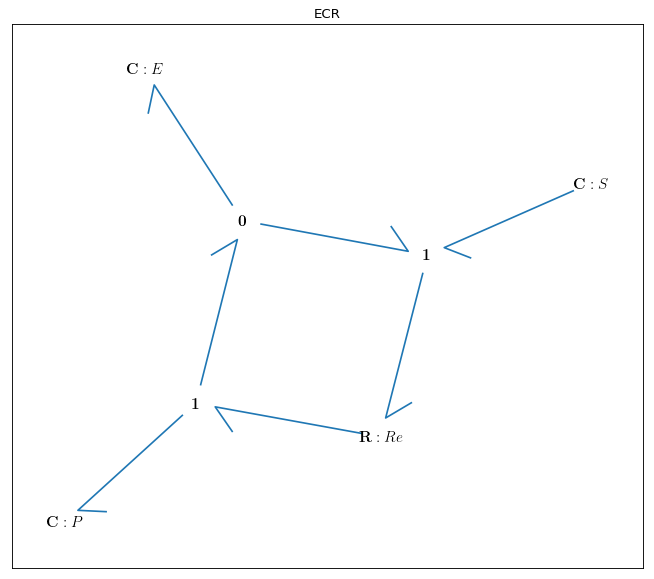

In [3]:
connect(substrate, one_s)
connect(zero_e, one_s)
connect(zero_e, enzyme)
connect(one_s, reaction)
connect(reaction, one_p)
connect(one_p, zero_e)
connect(one_p, product)
draw(model)

## Swapping components.

We can swap in different components using 'swap'

Constitutive relations:
dx_0 + u_9*exp((u_1*u_2*log(u_0*x_0) + u_4*u_5*log(u_3*x_1))/(u_10*u_11)) - u_9*exp((u_4*u_5*log(u_3*x_1) + u_7*u_8*log(u_6*x_2))/(u_10*u_11)) = 0
dx_1 = 0
dx_2 - u_9*exp((u_1*u_2*log(u_0*x_0) + u_4*u_5*log(u_3*x_1))/(u_10*u_11)) + u_9*exp((u_4*u_5*log(u_3*x_1) + u_7*u_8*log(u_6*x_2))/(u_10*u_11)) = 0


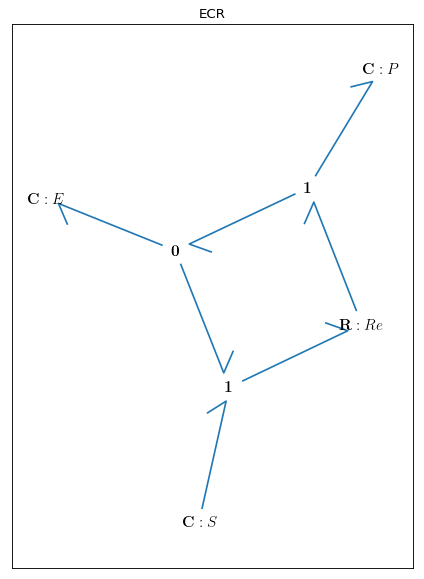

In [4]:
# Swap the 'C' component, which is linear, with a 'Ce' component, which is logarithmic.
old_product = product
old_substrate = substrate
old_enzyme = enzyme 

product = new("Ce",library="BioChem", name="P")
substrate = new("Ce",library="BioChem", name="S")
enzyme = new("Ce", library="BioChem", name="E")

swap(old_product, product)
swap(old_enzyme, enzyme)
swap(old_substrate, substrate)

draw(model)

print("Constitutive relations:")

for relation in model.constitutive_relations:
    print(f"{relation} = 0")


We can also 'expose' components, which essentially replaces one port components with SS components.

In [5]:
expose(product, label="P")
expose(substrate, label="S")

One can observe that this model now has additional effort and flow variables.

In [6]:
print("Constitutive relations:")

for relation in model.constitutive_relations:
    print(f"{relation} = 0")

print("\nParameters:")
for index, param in model.params.items():
    print(f"u_{index} is {param}")

print("\nExternal Ports:")
for port in model.ports:
    print(f"(e_{port.index}, f_{port.index}) maps to port {port.name}")

Constitutive relations:
dx_0 = 0
f_0 - u_3*exp((e_0 + u_1*u_2*log(u_0*x_0))/(u_4*u_5)) + u_3*exp((e_1 + u_1*u_2*log(u_0*x_0))/(u_4*u_5)) = 0
f_1 + u_3*exp((e_0 + u_1*u_2*log(u_0*x_0))/(u_4*u_5)) - u_3*exp((e_1 + u_1*u_2*log(u_0*x_0))/(u_4*u_5)) = 0

Parameters:
u_0 is (C: E, 'k')
u_1 is (C: E, 'R')
u_2 is (C: E, 'T')
u_3 is (R: Re, 'r')
u_4 is (R: Re, 'R')
u_5 is (R: Re, 'T')

External Ports:
(e_0, f_0) maps to port P
(e_1, f_1) maps to port S


## Saving and  Loading to file

Users can now save models to file. Here, we save to file and print the contents.

In [7]:
import pathlib
import yaml
path = pathlib.Path.cwd() / "catalysed_reaction.bg"

save(model, path)


In [8]:
print(f"Savingh to: {str(path)}\n")
print("File Contents:")
with open(str(path), 'r') as fs:
    print("".join(line for line in fs.readlines()))

Savingh to: /Users/Pete/Documents/projects/BondGraphTools-Tutorials/catalysed_reaction.bg

File Contents:
models:
  /:
    components:
    - 12 base/1
    - 01 base/0
    - P base/SS
    - S base/SS
    - 11 base/1
    - E BioChem/Ce
    - Re BioChem/Re
    netlist:
    - 11.output Re.0
    - 12.output 01
    - 01 E
    - Re.1 12.input
    - S 11.input
    - 12.output P
    - 01 11.input
    ports:
    - P P
    - S S
root: ECR
version: '0.1'



We can then go ahead an load the file into another model and draw it.
We also rename it so we can keep track of the two distinct copies we now have.

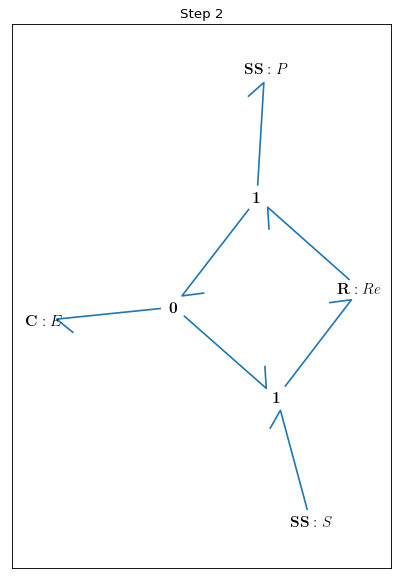

In [9]:
model.name = "Step 1"

second_reaction = load(path)
second_reaction.name = "Step 2"
draw(second_reaction)

## Wiring up modular components.

All this means that we can wire up components in a modular way.

In this case, we can use the two steps to make a reaction chain: 
S + E_1 = E_1 + I, 
I + E_2 = E_2 + P

And set the S, E to chemostats.

In [10]:
composite_model = new(name="Chained Reaction")
intermediate = new("Ce", library="BioChem")

zero_i = new("0")
zero_cp = new("0")
zero_cs = new("0")

Chemostat_P = new("Se", value=0)
Chemostat_S = new("Se", value=1)

components = [intermediate, zero_i, zero_cp, zero_cs, Chemostat_P, Chemostat_S, model, second_reaction]
add(composite_model, *components)  # *-operator here unpacks the list so that they're all arguments of add

for param in composite_model.params:
    set_param(composite_model, param, 1)

In [11]:
first_product_port, = (port for port in model.ports if port.name == "P")
first_substrate_port, = (port for port in model.ports if port.name == "S")

second_product_port, = (port for port in second_reaction.ports if port.name == "P")
second_substrate_port, = (port for port in second_reaction.ports if port.name == "S")

connect(Chemostat_S, zero_cs)
connect(zero_cs, first_substrate_port)

connect(first_product_port, zero_i)
connect(zero_i, second_substrate_port)
connect(zero_i, intermediate)

connect(second_product_port, zero_cp)
connect(zero_cp, Chemostat_P)

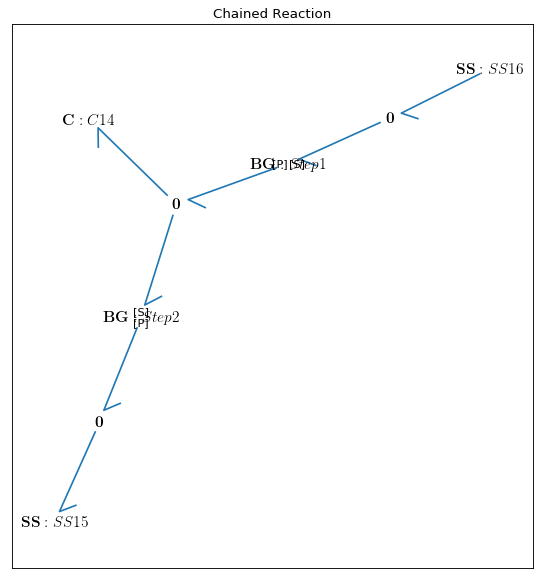

In [12]:
draw(composite_model)

## URI's

Subcomponents can now be found using their uri, accessed by component.uri.
This allow for easy access of any component by name.

/Step 1


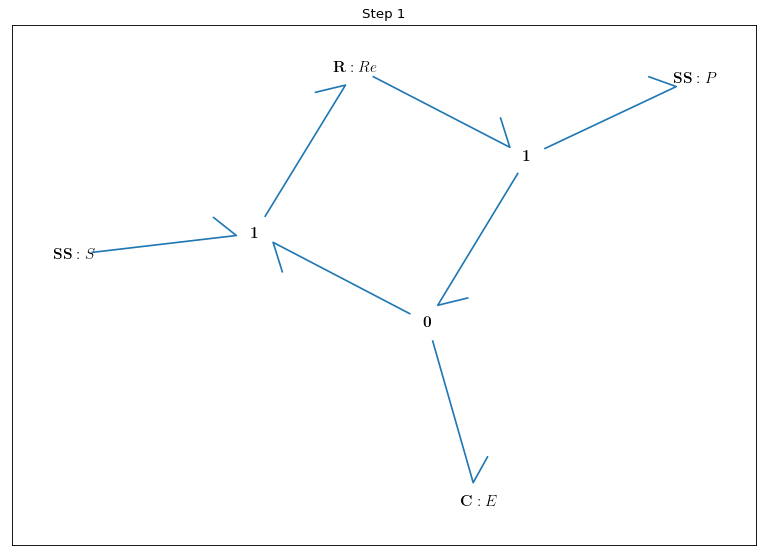

In [13]:
sub_model = composite_model / "Step 1"
print(sub_model.uri)
draw(sub_model)

Uri's of components in the submodel /Step 2:
/Step 2/01
/Step 2/P
/Step 2/12
/Step 2/11
/Step 2/E
/Step 2/Re
/Step 2/S


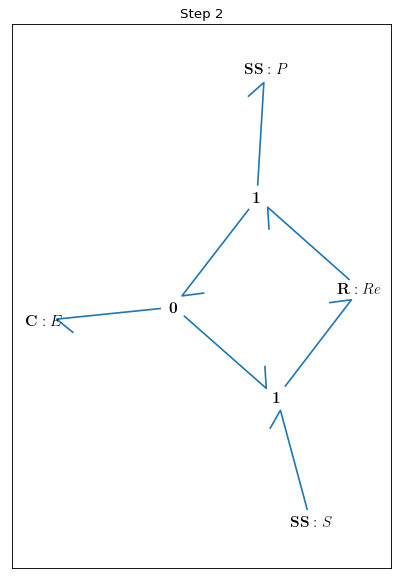

In [14]:
sub_model = composite_model / "Step 2"
print(f"Uri's of components in the submodel {sub_model.uri}:")
print("\n".join(c.uri for c in sub_model.components))
draw(composite_model / "Step 2")